<a href="https://colab.research.google.com/github/ejshumaker/EECS504Project/blob/work/EECS504FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 504 Final Project

### Bryan Edwards, Demba Komma, Leah Wu, Eric Shumaker
#### {bryaned, dbkomma, huiminwu, eshumake} @umich.edu


# Starting


In [44]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import cv2
import os

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


## [1] Download Pascal VOC 2007 dataset.



In [8]:
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar

--2020-04-11 00:56:46--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M   893KB/s    in 4m 59s  

2020-04-11 01:01:45 (1.47 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



# [1.1] Process images by masking center region

In [0]:
# Create directory structure for dataloader 
if os.path.exists('./data'):
  ! rm -r ./data
os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/train/sub')
os.mkdir('./data/test')
os.mkdir('./data/test/sub')
train_path = './data/train/sub'
test_path = './data/test/sub'

In [0]:
def process_image(img_path):
    """
    Resizes and masks image in specified path.

    Input:
    - img_path: path to image

    Output:
    - Image of size (454,227,3) containing resized original image in left half and
      resized, masked image in right half
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (227,227)) # Resize image to (227,227,3)

    # Create mask
    mask = 255 * np.ones_like(img)
    x,y,_ = mask.shape
    mask[int(x/3):int((2/3)*x), int(y/3):int((2/3)*y),:] = 0

    # Apply mask
    masked = cv2.bitwise_and(img,mask)

    # Concatenate original img with masked
    cat = np.hstack((img, masked))
    return cat
  

In [0]:
# # To clean folders
if len(os.listdir(train_path)) != 0:
  for root, dirs, files in os.walk(train_path):
      for img in files:
          os.remove(os.path.join(root, img))

  for root, dirs, files in os.walk(test_path):
      for img in files:
          os.remove(os.path.join(root, img))

In [48]:
path = './VOCdevkit/VOC2007/JPEGImages'
images = []

for filename in os.listdir(path):
    img = process_image(os.path.join(path, filename))
    if img is not None:
        images.append(img)

# Take last 500 images as test data
train = images[:-500]
test = images[-500:]

# Add training images to train directory
if len(os.listdir(train_path)) == 0:
    for i, img in enumerate(train):
        img_path = train_path + '/%d.jpg' % (i + 1)
        cv2.imwrite(img_path, img)
    print('Train images saved to train directory')
else:
    print('Please empty {} directory.'.format(train_path))

# Add test images to test directory
if len(os.listdir(test_path)) == 0:
    for i, img in enumerate(test):
        img_path = test_path + '/%d.jpg' % (i + 1)
        cv2.imwrite(img_path, img)
    print('Test images saved to test directory')
else:
    print('Please empty {} directory.'.format(test_path))

Train images saved to train directory
Test images saved to test directory


## [2] Build dataloaders for train and test

In [0]:
def load_data(path, subfolder, transform, batch_size, shuffle=True):
    """
    Data loader.

    Inputs:
    - path: path of the data.
    - subfolder: subfolder of the data.
    - transform: data transformation.
    - batch_size: the size of the batch
    - shuffle: if true, shuffle the data

    Outputs:
    - torch Dataloader
    """
    direc = path + '/' + subfolder
    dset = datasets.ImageFolder(direc, transform=transform)

    # For debugging faster, truncate data to 2500 images for training and 10 for validating
    if subfolder == 'train':
      dset_sub = Subset(dset, torch.arange(0, 2500))
    elif subfolder == 'test':
      dset_sub = Subset(dset, torch.arange(0, 10))

    dataloader = DataLoader(dset,batch_size=batch_size,shuffle=shuffle)
    return dataloader

In [0]:
# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = load_data('./data', 'train', transform, 1, shuffle=True)
test_loader = load_data('./data', 'test', transform, 10, shuffle=False)

#Sample Output used for visualization
test = test_loader.__iter__().__next__()[0]
img_size = test.size()[2]
fixed_y_ = test[:, :, :, 0:img_size]
fixed_x_ = test[:, :, :, img_size:]

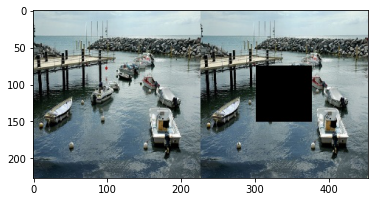

In [62]:
# plot sample image
example = train_loader.__iter__().__next__()[0][0].numpy().transpose((1, 2, 0))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
example = std * example + mean
plt.imshow(example)
plt.show()

## [3] Define Architecture

In [0]:
# TODO

## [4] Train



In [0]:
def visualize_recon(model, dataloader):
    '''
    Helper function for visualizing reconstruction performance.

    Randomly sample 8 images and plot the original/reconstructed images. 
    '''
    model.eval()
    img = next(iter(dataloader))[0][:4].to(device)
    img = img[:,-227:,:]
    out = model(img)

    fig, ax = plt.subplots(1, 1, figsize=(30,20))
    inp = torchvision.utils.make_grid(torch.cat((img, out), dim=2), nrow=4)
    imshow(inp.detach().cpu(), ax=ax)
    model.train()
    plt.show()

In [0]:
def train(model, dataloader, num_epochs=200):
    '''
    Train Image Inpainting model.

    Args:
        model: torch.nn.module.
        dataloader: DataLoader
    '''


    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = None
    loss_overall = []


    print('training start!')
    start_time = time.time()

    for epoch in range(num_epochs):
        print('Start training epoch %d' % (epoch + 1))
        loss_epoch = 0
        for img, _ in dataloader:
          
            # TODO:                               
           
            

        loss_overall.append(loss_epoch)

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
        
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.3f}'.format(epoch, loss_epoch))
            print('[%d/%d] - using time per epoch: %.2f' % (per_epoch_ptime))
            visualize_recon(model, dataloader)

    end_time = time.time()
    total_ptime = end_time - start_time

    return model, loss_overall

## [5] Visualization



In [0]:
# 




